In [3]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from Utils.recsys2022DataReader import *

In [4]:
URM_init = load_BinURMTrainInit()
URM_train = load_1K_BinURMTrain()[0]
URM_validation = load_1K_BinURMValid()[0]
URM_test = load_BinURMTest()

In [5]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

candidate_generator_recommender = RP3betaRecommender(URM_train)
candidate_generator_recommender.fit(topK=50, alpha=0.7179592867915304, beta=0.3290994149353332)

RP3betaRecommender: Similarity column 24507 (100.0%), 4139.61 column/sec. Elapsed time 5.92 sec


## Building dataframe

In [6]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [7]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
41624,NaN
41625,NaN
41626,NaN


In [8]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 41629/41629 [00:15<00:00, 2704.31it/s]


In [9]:
training_dataframe

,ItemID
UserID,
0,"[5735, 20, 391, 23, 828, 29, 2495, 752, 25, 61..."
1,"[6874, 20379, 665, 249, 13968, 9636, 14363, 11..."
2,"[453, 121, 7864, 617, 126, 676, 391, 15454, 67..."
3,"[20, 58, 352, 269, 22, 393, 1746, 1967, 61, 59..."
4,"[23, 25, 124, 53, 21, 353, 80, 71, 436, 67, 68..."
...,...
41624,"[14400, 22403, 7864, 10221, 14809, 18939, 1155..."
41625,"[56, 53, 1032, 17589, 21, 1026, 23, 1449, 1965..."
41626,"[56, 24064, 15229, 1693, 14551, 3535, 61, 2254..."


In [10]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,5735
0,20
0,391
0,23
0,828
...,...
41628,6703
41628,21722
41628,19424


## Add validation test

In [11]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,575
1,0,4337
2,0,6351
3,0,10682
4,0,16868
...,...,...
198212,41628,5878
198213,41628,6219
198214,41628,9000
198215,41628,14567


In [12]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,5735,left_only
1,0,20,left_only
2,0,391,left_only
3,0,23,left_only
4,0,828,left_only
...,...,...,...
1248865,41628,6703,left_only
1248866,41628,21722,left_only
1248867,41628,19424,left_only
1248868,41628,22181,left_only


In [13]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,5735,False
1,0,20,False
2,0,391,False
3,0,23,False
4,0,828,False
...,...,...,...
1248865,41628,6703,False
1248866,41628,21722,False
1248867,41628,19424,False
1248868,41628,22181,False


## Now we add some features like different recommenders predictions

In [14]:
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender

ICM = createSmallICM()

ItemKNN = ItemKNNCFRecommender(URM_train)
ItemKNN.fit(ICM=ICM, topK=584, shrink=919, similarity="dice", normalization="bm25")

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit(topK=116, alpha=0.8763131065621229)

#IALS = ImplicitALSRecommender(URM_train)
#IALS.fit(factors=110, alpha=7, iterations=57, regularization=0.0008866558623568822)

other_algorithms = {
    "ItemKNN": ItemKNN,
    "P3alpha": P3alpha,
    #"IALS": IALS,
}

Done: 100%|██████████| 24507/24507 [00:08<00:00, 2872.46it/s]            


P3alphaRecommender: Similarity column 24507 (100.0%), 3681.48 column/sec. Elapsed time 6.66 sec


In [15]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 41629/41629 [00:39<00:00, 1044.45it/s]


,UserID,ItemID,Label,ItemKNN,P3alpha
0,0,5735,False,1.886544,0.038573
1,0,20,False,2.157015,0.032121
2,0,391,False,1.810424,0.032799
3,0,23,False,2.124116,0.050202
4,0,828,False,1.957499,0.024736
...,...,...,...,...,...
1248865,41628,6703,False,0.391042,0.008965
1248866,41628,21722,False,0.394461,0.008719
1248867,41628,19424,False,0.508864,0.008857
1248868,41628,22181,False,0.463089,0.010560


## We add the item popularity and profile length

In [16]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,item_popularity
0,0,5735,False,1.886544,0.038573,324
1,0,20,False,2.157015,0.032121,3598
2,0,391,False,1.810424,0.032799,279
3,0,23,False,2.124116,0.050202,3121
4,0,828,False,1.957499,0.024736,825
...,...,...,...,...,...,...
1248865,41628,6703,False,0.391042,0.008965,24
1248866,41628,21722,False,0.394461,0.008719,23
1248867,41628,19424,False,0.508864,0.008857,16
1248868,41628,22181,False,0.463089,0.010560,21


In [17]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,item_popularity,user_profile_len
0,0,5735,False,1.886544,0.038573,324,47
1,0,20,False,2.157015,0.032121,3598,47
2,0,391,False,1.810424,0.032799,279,47
3,0,23,False,2.124116,0.050202,3121,47
4,0,828,False,1.957499,0.024736,825,47
...,...,...,...,...,...,...,...
1248865,41628,6703,False,0.391042,0.008965,24,14
1248866,41628,21722,False,0.394461,0.008719,23,14
1248867,41628,19424,False,0.508864,0.008857,16,14
1248868,41628,22181,False,0.463089,0.010560,21,14


In [18]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,ItemKNN,P3alpha,item_popularity,user_profile_len
0,0,5735,False,1.886544,0.038573,324,47
1,0,3391,False,0.927966,0.021100,212,47
2,0,1648,False,1.105758,0.000000,1370,47
3,0,4577,False,0.934707,0.022408,223,47
4,0,5070,False,0.870980,0.021523,195,47
...,...,...,...,...,...,...,...
1248865,41628,2904,False,1.639046,0.019774,88,14
1248866,41628,769,False,2.373099,0.034845,117,14
1248867,41628,22181,False,0.463089,0.010560,21,14
1248868,41628,897,False,0.569218,0.007158,101,14


## Train XGBoost

In [19]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [20]:
from xgboost import XGBRanker

In [21]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [22]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=True, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [33]:
X_to_predict = X_train[X_train["UserID"] == 0]

XGB_model.predict(X_to_predict)

array([ 0.61526287,  0.42317045,  0.1143931 ,  0.42317045,  0.42317045,
        0.52949554,  0.197924  ,  0.586609  , -2.4397874 ,  0.21627763,
        0.46798825,  0.197924  ,  0.21627763,  0.197924  ,  0.586609  ,
        0.3416813 ,  0.17484385,  0.28172767,  0.8313922 ,  0.586609  ,
        0.36377037,  0.56987286,  0.197924  ,  0.5805862 ,  0.53760964,
        0.60245657,  0.586609  ,  0.586609  ,  0.17484385,  0.586609  ],
      dtype=float32)

In [25]:
predictions = XGB_model.predict(X_to_predict)

In [26]:
len(predictions)

30

In [48]:
predictions

array([-2.5168478 , -2.5168478 , -2.5168478 , -2.5168478 , -2.5168478 ,
       -2.5168478 , -2.5168478 , -2.5069976 , -1.5838032 , -0.89722914,
        0.07954384,  0.08402009,  0.1021487 ,  0.1021487 ,  0.14843109,
        0.15793152,  0.16972236,  0.26152292,  0.31325793,  0.37091306,
        0.4387741 ,  0.58692884,  0.6935954 ,  0.7589379 ,  0.7647922 ,
        0.8221102 ,  0.89217746,  0.98836696,  1.6048934 ,  1.6434541 ],
      dtype=float32)

In [46]:
user = 0
items = training_dataframe.loc[training_dataframe["UserID"]==user]
items = items["ItemID"]
items

0      5735
1      3391
2      1648
3      4577
4      5070
5       149
6      2077
7      2494
8      8789
9       299
10     2792
11      679
12    14710
13     1534
14     2488
15      107
16     3608
17     2019
18       20
19      391
20       23
21      828
22     2495
23       29
24       25
25      617
26      353
27    18484
28      771
29      752
Name: ItemID, dtype: object

In [52]:
predictionsToSubmit = {}
i = 0
for item in items:
    predictionsToSubmit[item] = predictions[i]
    i+=1

In [53]:
predictionsToSubmit

{5735: -2.5168478,
 3391: -2.5168478,
 1648: -2.5168478,
 4577: -2.5168478,
 5070: -2.5168478,
 149: -2.5168478,
 2077: -2.5168478,
 2494: -2.5069976,
 8789: -1.5838032,
 299: -0.89722914,
 2792: 0.079543844,
 679: 0.08402009,
 14710: 0.102148704,
 1534: 0.102148704,
 2488: 0.14843109,
 107: 0.15793152,
 3608: 0.16972236,
 2019: 0.26152292,
 20: 0.31325793,
 391: 0.37091306,
 23: 0.4387741,
 828: 0.58692884,
 2495: 0.6935954,
 29: 0.7589379,
 25: 0.7647922,
 617: 0.8221102,
 353: 0.89217746,
 18484: 0.98836696,
 771: 1.6048934,
 752: 1.6434541}

In [57]:
SortedPredictions = sorted(predictionsToSubmit.values(), reverse=True)
SortedPredictions

[1.6434541,
 1.6048934,
 0.98836696,
 0.89217746,
 0.8221102,
 0.7647922,
 0.7589379,
 0.6935954,
 0.58692884,
 0.4387741,
 0.37091306,
 0.31325793,
 0.26152292,
 0.16972236,
 0.15793152,
 0.14843109,
 0.102148704,
 0.102148704,
 0.08402009,
 0.079543844,
 -0.89722914,
 -1.5838032,
 -2.5069976,
 -2.5168478,
 -2.5168478,
 -2.5168478,
 -2.5168478,
 -2.5168478,
 -2.5168478,
 -2.5168478]

In [29]:
predictions.sort()
predictions

array([-2.5168478 , -2.5168478 , -2.5168478 , -2.5168478 , -2.5168478 ,
       -2.5168478 , -2.5168478 , -2.5069976 , -1.5838032 , -0.89722914,
        0.07954384,  0.08402009,  0.1021487 ,  0.1021487 ,  0.14843109,
        0.15793152,  0.16972236,  0.26152292,  0.31325793,  0.37091306,
        0.4387741 ,  0.58692884,  0.6935954 ,  0.7589379 ,  0.7647922 ,
        0.8221102 ,  0.89217746,  0.98836696,  1.6048934 ,  1.6434541 ],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

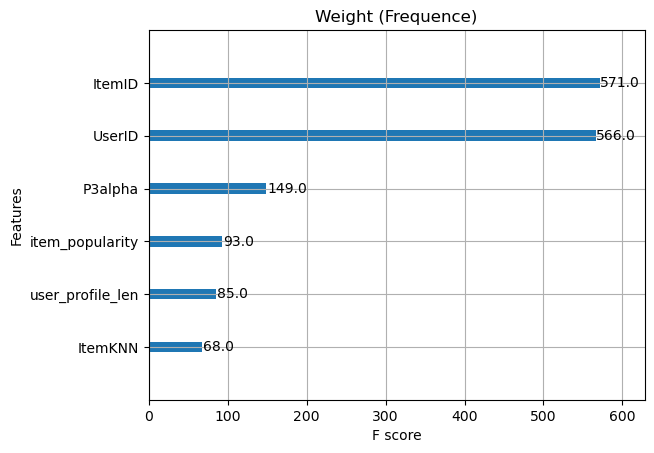

In [24]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')